# Think Bayes

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [11]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeJoint, MakeNormalPmf

import thinkbayes2
import thinkplot

import numpy as np

## The Weibull distribution

The Weibull distribution is often used in survival analysis because it models the distribution of lifetimes for manufactured products, at least over some parts of the range.

The following functions evaluate its PDF and CDF.

In [2]:
def EvalWeibullPdf(x, lam, k):
    """Computes the Weibull PDF.

    x: value
    lam: parameter lambda in events per unit time
    k: parameter

    returns: float probability density
    """
    arg = (x / lam)
    return k / lam * arg**(k-1) * np.exp(-arg**k)

def EvalWeibullCdf(x, lam, k):
    """Evaluates CDF of the Weibull distribution."""
    arg = (x / lam)
    return 1 - np.exp(-arg**k)

def MakeWeibullPmf(lam, k, high, n=200):
    """Makes a PMF discrete approx to a Weibull distribution.

    lam: parameter lambda in events per unit time
    k: parameter
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    xs = np.linspace(0, high, n)
    ps = EvalWeibullPdf(xs, lam, k)
    return Pmf(dict(zip(xs, ps)))

SciPy also provides functions to evaluate the Weibull distribution, which I'll use to check my implementation.

In [3]:
from scipy.stats import weibull_min

lam = 2
k = 1.5
x = 0.5

weibull_min.pdf(x, k, scale=lam)

0.3309363384692233

In [4]:
EvalWeibullPdf(x, lam, k)

0.3309363384692233

In [5]:
weibull_min.cdf(x, k, scale=lam)

0.1175030974154046

In [6]:
EvalWeibullCdf(x, lam, k)

0.11750309741540454

And here's what the PDF looks like, for these parameters.

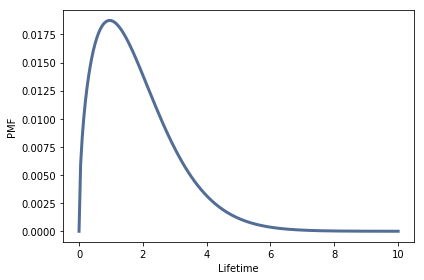

In [7]:
pmf = MakeWeibullPmf(lam, k, high=10)
thinkplot.Pdf(pmf)
thinkplot.decorate(xlabel='Lifetime',
                   ylabel='PMF')

We can use `np.random.weibull` to generate random values from a Weibull distribution with given parameters.

To check that it is correct, I generate a large sample and compare its CDF to the analytic CDF.

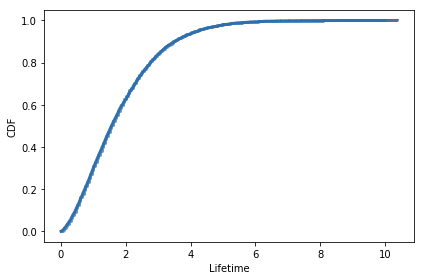

In [8]:
def SampleWeibull(lam, k, n=1):
    return np.random.weibull(k, size=n) * lam

data = SampleWeibull(lam, k, 10000)
cdf = Cdf(data)
model = pmf.MakeCdf()
thinkplot.Cdfs([cdf, model])
thinkplot.decorate(xlabel='Lifetime',
                   ylabel='CDF')

**Exercise:** Write a class called `LightBulb` that inherits from `Suite` and `Joint` and provides a `Likelihood` function that takes an observed lifespan as data and a tuple, `(lam, k)`, as a hypothesis.  It should return a likelihood proportional to the probability of the observed lifespan in a Weibull distribution with the given parameters.

Test your method by creating a `LightBulb` object with an appropriate prior and update it with a random sample from a Weibull distribution.

Plot the posterior distributions of `lam` and `k`.  As the sample size increases, does the posterior distribution converge on the values of `lam` and `k` used to generate the sample?

In [54]:
class Lightbulb(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        observed_life = data
        lam, k = hypo  # Model parameters
        
        if lam < 0 or k < 0:
            return 0
        
        return EvalWeibullPdf(k=k, lam=lam, x=observed_life)

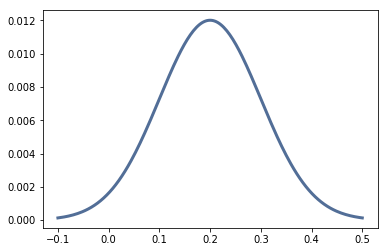

In [55]:
# Lightbulbs fail after 5 years
prior_lam = MakeNormalPmf(mu=0.2,sigma=0.1,num_sigmas=3)
thinkplot.Pdf(prior_lam)

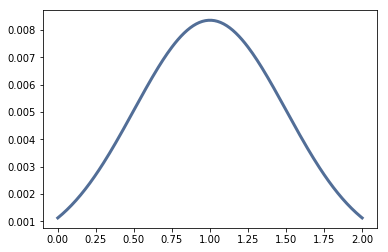

In [56]:
prior_k = MakeNormalPmf(1, 0.5, 2)
thinkplot.Pdf(prior_k)

/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
No handles with labels found to put in legend.


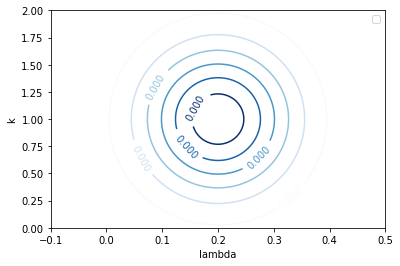

In [57]:
prior = MakeJoint(prior_lam, prior_k)

thinkplot.Contour(prior)
thinkplot.Config(xlabel='lambda', ylabel='k')

posterior = Lightbulb(prior);

In [98]:
posterior.Update(5000)

8.577280416039679e-10

/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


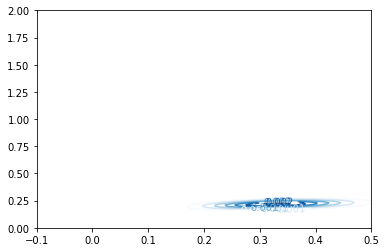

In [99]:
thinkplot.Contour(posterior)

In [9]:
# Solution goes here

In [10]:
# Solution goes here

In [11]:
# Solution goes here

In [12]:
# Solution goes here

In [13]:
# Solution goes here

In [14]:
# Solution goes here

**Exercise:** Now suppose that instead of observing a lifespan, `k`, you observe a lightbulb that has operated for 1 year and is still working.  Write another version of `LightBulb` that takes data in this form and performs an update. 

In [15]:
# Solution goes here

In [16]:
# Solution goes here

In [17]:
# Solution goes here

In [18]:
# Solution goes here

In [19]:
# Solution goes here

In [20]:
# Solution goes here

**Exercise:** Now let's put it all together.  Suppose you have 15 lightbulbs installed at different times over a 10 year period.  When you observe them, some have died and some are still working.  Write a version of `LightBulb` that takes data in the form of a `(flag, x)` tuple, where:

1. If `flag` is `eq`, it means that `x` is the actual lifespan of a bulb that has died.
2. If `flag` is `gt`, it means that `x` is the current age of a bulb that is still working, so it is a lower bound on the lifespan.

To help you test, I will generate some fake data.

First, I'll generate a Pandas DataFrame with random start times and lifespans.  The columns are:

`start`: time when the bulb was installed

`lifespan`: lifespan of the bulb in years

`end`: time when bulb died or will die

`age_t`: age of the bulb at t=10

In [21]:
import pandas as pd

lam = 2
k = 1.5
n = 15
t_end = 10
starts = np.random.uniform(0, t_end, n)
lifespans = SampleWeibull(lam, k, n)

df = pd.DataFrame({'start': starts, 'lifespan': lifespans})
df['end'] = df.start + df.lifespan
df['age_t'] = t_end - df.start

df.head()

Now I'll process the DataFrame to generate data in the form we want for the update.

In [22]:
data = []
for i, row in df.iterrows():
    if row.end < t_end:
        data.append(('eq', row.lifespan))
    else:
        data.append(('gt', row.age_t))
        
for pair in data:
    print(pair)

In [23]:
# Solution goes here

In [24]:
# Solution goes here

In [25]:
# Solution goes here

In [26]:
# Solution goes here

In [27]:
# Solution goes here

**Exercise:** Suppose you install a light bulb and then you don't check on it for a year, but when you come back, you find that it has burned out.  Extend `LightBulb` to handle this kind of data, too.

In [28]:
# Solution goes here

## Prediction

**Exercise:** Suppose we know that, for a particular kind of lightbulb in a particular location, the distribution of lifespans is well modeled by a Weibull distribution with `lam=2` and `k=1.5`.  If we install `n=100` lightbulbs and come back one year later, what is the distribution of `c`, the number of lightbulbs that have burned out?

In [29]:
# Solution goes here

In [30]:
# Solution goes here

**Exercise:** Now suppose that `lam` and `k` are not known precisely, but we have a `LightBulb` object that represents the joint posterior distribution of the parameters after seeing some data.  Compute the posterior predictive distribution for `c`, the number of bulbs burned out after one year.

In [31]:
# Solution goes here

In [32]:
# Solution goes here